In [ ]:
#For preprocess
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string
from string import punctuation
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import gensim
from IPython.display import display, HTML
from nltk.corpus import wordnet

#Keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


 **Load data file**

In [ ]:
filepath = "topic_with_sentiment.csv"

In [ ]:
data = pd.read_csv(filepath, sep=",", error_bad_lines=False, encoding='latin-1')

In [ ]:
data.head()

,Text,Topic_assigned,Topic_Percentage,Ground_Truth,Ground_Truth_Sentiment
0,pleasure ing 7 night recently perfect every wa...,Service,0.2340,Facilities Comfort Food Staff Location Service,5
1,lovely first visit iconic bar wonderful servic...,Service,0.2886,Food Price Service,5
2,3 u ed rhodes_hotel 4 night location take padd...,Price,0.1645,Facilities Cleanliness Staff Location,4
3,form moment_arrive left experienced absolute_p...,Service,0.2637,Food Staff Service,5
4,well strange 5star new come along eager try he...,Staff,0.2831,Facilities Cleanliness Food Price Staff Service,1


**Preprocess**

In [ ]:
def preprocess(text):

    #tokenizer = RegexpTokenizer(r'\w+')
    #for t in text:
    #    tokenizer.tokenize(t)

    #tokenizing
    for sent in text:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))


    # lowercasing
    text = [str(t).lower() for t in text]

    text = [t for t in text if t.isalpha()]
    
    #table = str.maketrans('', '', string.punctuation)
    #stripped = [t.translate(table) for t in text]


    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    text = [lemmatiser.lemmatize(t) for t in text]
    #, get_wordnet_pos(t)

    # remove numbers and empty space
    digits = ' 0123456789'
    text = [t for t in text if t not in digits]

    return text

In [ ]:
def preProcess(text):
    # should return a list of tokens
    
    # word tokenisation, including punctuation removal
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # lowercasing
    tokens = [t.lower() for t in tokens]

    # stopword removal- benefits are it removes rare words, though bad for bigram relations
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop]
    
    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t] # ensure no empty space

    # remove numbers
    digits = '0123456789'
    text = [t for t in text if t not in digits]
    
    return tokens

In [ ]:
def create_bigrams(words):
    bigram = gensim.models.Phrases(words, min_count=2, threshold=30)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

**Prepare data to train**

In [ ]:
topic = ['Staff, Location', 
         'Location', 
         'Comfort, Clealiness', 
         'Facilities', 
         'Location, Food', 
         'Food',
         'Staff', 
         'Service', 
         'Price']

In [ ]:
subgroup = data[data.Topic_assigned == topic[0]]

In [ ]:
subgroup.head()

,Text,Topic_assigned,Topic_Percentage,Ground_Truth,Ground_Truth_Sentiment
23,family trip ing business district location con...,"Staff, Location",0.1467,Facilities Cleanliness Food Staff Location,4
36,host help every aspect way place nice clean va...,"Staff, Location",0.1315,Cleanliness Price Staff,5
39,cosy small read tiny modern spotlessly clean l...,"Staff, Location",0.1435,Facilities Cleanliness Comfort Food Staff Loc...,4
81,friendly attentive personal service staff exce...,"Staff, Location",0.1434,Facilities Food Staff Service,5
108,good customer service comfortable amenity big ...,"Staff, Location",0.1472,Facilities Comfort Food Staff Service,5


Cleaning data (remove minor reviews, replace 5 labels with 3 labels)

In [ ]:
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 0]
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 6]
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 7]
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 8]
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 9]
subgroup = subgroup[subgroup.Ground_Truth_Sentiment != 10]

In [ ]:
subgroup['Ground_Truth_Sentiment'] = subgroup['Ground_Truth_Sentiment'].replace(1, 0)
subgroup['Ground_Truth_Sentiment'] = subgroup['Ground_Truth_Sentiment'].replace(2, 0)

In [ ]:
subgroup['Ground_Truth_Sentiment'] = subgroup['Ground_Truth_Sentiment'].replace(4, 2)
subgroup['Ground_Truth_Sentiment'] = subgroup['Ground_Truth_Sentiment'].replace(5, 2)

In [ ]:
subgroup['Ground_Truth_Sentiment'] = subgroup['Ground_Truth_Sentiment'].replace(3, 1)

In [ ]:
subgroup['Ground_Truth_Sentiment'].value_counts()

2    70120
1     8069
0     1832
Name: Ground_Truth_Sentiment, dtype: int64

Apply preprocess

In [ ]:
subgroup['processed'] = subgroup['Text'].apply(preProcess)

In [ ]:
x_raw = subgroup['processed'].values.tolist()

In [ ]:
bigram_mod = create_bigrams(x_raw)
x = [bigram_mod[line] for line in x_raw]

x_train = [' '.join(i) for i in x]

In [ ]:
print(len(x_train))

80021


Create dictionary

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras_preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(x_train)

#create dictionary to map words with ids
word2idx = tokenizer.word_index
word2idx['PAD'] = 0

#create dictionary to map ids with words2
idx2word = {v:k for k, v in word2idx.items()}
word_ids = [[word2idx[w] for w in text.text_to_word_sequence(doc)] for doc in x_train]


vocab_size = len(word2idx) + 1
embed_size = 100

Load Trained Word Embeddings

In [ ]:
#word2vec file name
fpath = '/content/drive/My Drive/Final Project MSC AI/result/word2vec/word2vec.h5'

In [ ]:
from keras.models import load_model
model2 = load_model(fpath)

In [ ]:
word_embeddings = model2.get_layer('target_embed_layer').get_weights()[0][1:]

In [ ]:
embeddings_index = {w:word_embeddings[idx] for w, idx in word2idx.items()}

In [ ]:
from numpy import zeros

embedding_matrix = zeros((vocab_size, 100))
for word, i in word2idx.items():

    embedding_matrix[i, :] = embeddings_index[word]


In [ ]:
embeddingLayer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], trainable=True)

Prepare data for Keras

In [ ]:
from keras.utils import to_categorical

Y_train = to_categorical(subgroup['Ground_Truth_Sentiment'].values)

In [ ]:
#from keras.preprocessing.text import Tokenizer
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)

In [ ]:
#padding
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 500
EMBED_SIZE = 100

train_data = sequence.pad_sequences(X_train, maxlen=MAXIMUM_LENGTH)
#test_data = sequence.pad_sequences(X_test, maxlen=MAXIMUM_LENGTH)

Splitting training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, Y_train, test_size=0.1)

Define Model

In [ ]:
model = Sequential()
model.add(embeddingLayer)
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
#model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
#model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#model.load_weights("weights.best.hdf5")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1497300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 1,578,003
Trainable params: 1,578,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_valid, y_valid = X_train[:500], y_train[:500]
X_train, y_train = X_train[500:], y_train[500:]

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
batch_size = 100
num_epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs, callbacks=[earlyStopping, mcp_save], shuffle=True)

Epoch 1/10
716/716 [==============================] - 1247s 2s/step - loss: 0.4120 - accuracy: 0.8745 - val_loss: 0.3635 - val_accuracy: 0.8820
Epoch 2/10
716/716 [==============================] - 1242s 2s/step - loss: 0.3696 - accuracy: 0.8758 - val_loss: 0.3559 - val_accuracy: 0.8840
Epoch 3/10
716/716 [==============================] - 1245s 2s/step - loss: 0.3555 - accuracy: 0.8762 - val_loss: 0.3569 - val_accuracy: 0.8840
Epoch 4/10
716/716 [==============================] - 1289s 2s/step - loss: 0.3447 - accuracy: 0.8772 - val_loss: 0.3633 - val_accuracy: 0.8840
Epoch 5/10
716/716 [==============================] - 1299s 2s/step - loss: 0.3355 - accuracy: 0.8791 - val_loss: 0.3653 - val_accuracy: 0.8820
Epoch 6/10
716/716 [==============================] - 1308s 2s/step - loss: 0.3290 - accuracy: 0.8811 - val_loss: 0.3754 - val_accuracy: 0.8720
Epoch 7/10
716/716 [==============================] - 1306s 2s/step - loss: 0.3196 - accuracy: 0.8855 - val_loss: 0.3837 - val_accuracy:

In [ ]:
from keras.models import load_model

model.save('largest.h5')

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

Visualisation of results

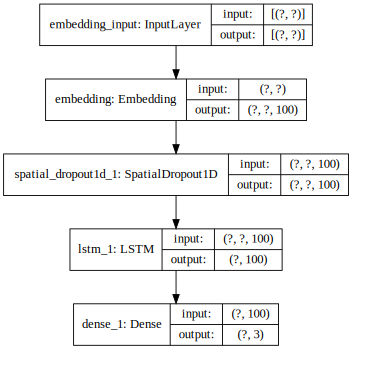

In [ ]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

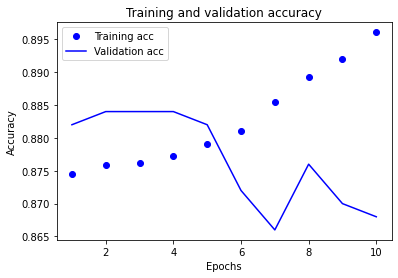

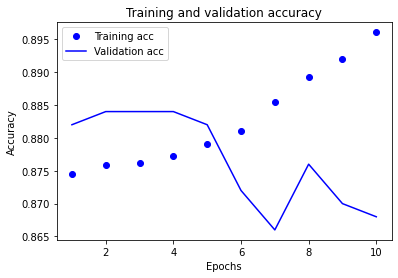

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

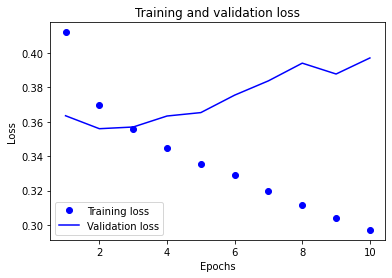

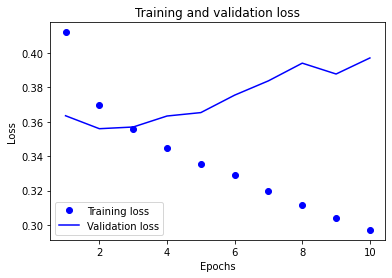

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)
print('test_loss:', results[0], 'test_accuracy:', results[1])

251/251 [==============================] - 31s 123ms/step - loss: 0.4080 - accuracy: 0.8604
test_loss: 0.40795132517814636 test_accuracy: 0.8604273200035095
251/251 [==============================] - 31s 122ms/step - loss: 0.4080 - accuracy: 0.8604
test_loss: 0.40795132517814636 test_accuracy: 0.8604273200035095


Create table with prediction

In [ ]:
tokenizer.fit_on_texts(x_train)
a = tokenizer.texts_to_sequences(x_train)
b = sequence.pad_sequences(a, maxlen=MAXIMUM_LENGTH)


In [ ]:
subgroup['Prediction'] = model.predict_classes(b, batch_size=batch_size, verbose=1)

801/801 [==============================] - 100s 125ms/step


In [ ]:
subgroup = subgroup.drop(columns='processed')

In [ ]:
from IPython.display import display, HTML

display(HTML(subgroup.to_html()[:10000]))

,Text,Topic_assigned,Topic_Percentage,Ground_Truth,Ground_Truth_Sentiment,Prediction
23,family trip ing business district location convenient get connection shopping area tube room nice clean appreciate much reception staff restaurant staff helpful friendly especially lady name eva reception restaurant staff remember drink order 2nd visit bkf welcome enjoy lot,"Staff, Location",0.1467,Facilities Cleanliness Food Staff Location,2,2
36,host help every aspect way place nice clean value situate nice area staff friendly,"Staff, Location",0.1315,Cleanliness Price Staff,2,2
39,cosy small read tiny modern spotlessly clean location service friendly helpful breakfast right wifi free charge reception could well though warmly recommend want decent place,"Staff, Location",0.1435,Facilities Cleanliness Comfort Food Staff Location Service,2,2
81,friendly attentive personal service staff excellent facility quality standard although small give ample space overnight lovely en_suite tea_coffee tray skimp towel,"Staff, Location",0.1434,Facilities Food Staff Service,2,2
108,good customer service comfortable amenity big tub shower love tea_coffee service extra water staff always available willing_help accommodate staff really top_notch,"Staff, Location",0.1472,Facilities Comfort Food Staff Service,2,2
198,year_ago family must say enjoy staff friendly efficient clean tidy breakfast plentiful convenient service excellent quality price,"Staff, Location",0.1588,Facilities Cleanliness Food Price Staff Service,2,2
222,business 10 colleague never sure location property etc awesome staff impeccable every incredibly helpful even last minute request food cocktail location perfect definitely,"Staff, Location",0.1371,Food Staff Location,2,2
282,location excellent short walk paddington_lancaster gate single basic clean breakfast well staff polite helpful overall would recommend base value safety cleanliness,"Staff, Location",0.1559,Facilities Cleanliness Food Price Staff Location,2,2
291,nice excellent location right thames reception staff polite helpful room size shower rooftop bar summer tube stop 3 minute walk satisfy,"Staff, Location",0.1458,Facilities Food Staff Location,2,2
382,well friendly extremely helpful owner could enough help although compact plenty storage spotlessly clean ed two occasion trip must best value close everything breakfast,"Staff, Location",0.1577,Facilities Cleanliness Food Price Staff,2,2
